In [20]:
from util.TSP_GA import create_locations ,GeneticAlgo,Location
from util.APF_PATH import APF , Vector2d , plot_obs_n_start_n_goal
from matplotlib import pyplot as plt
import time
import json
import pandas as pd
import numpy as np
import copy
import os , glob
from PIL import Image


In [21]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.jpg")]
    frame_one = frames[0]
    frame_one.save(f"{frame_folder}.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
def make_nodes_dataframe(nodes_list , nide_num = 10,max_time = 60 , **kwargs):
    global x
    x = np.random.randint(max_time,size=(nide_num,nide_num)).astype('float32')
    nan_diag = np.diag(tuple([np.nan for _ in range(nide_num)]))
    if list(kwargs.keys())[0] =='customized_nan':
        for k,v in list(kwargs.values())[0].items():
            x[nodes_list.index(v),nodes_list.index(k)] = np.nan
    return x+nan_diag
# make_nodes_dataframe
class check_table:
    def __init__(self, json_time_table, json_weight_table):
        self.json_time_table = json_time_table
        self.json_weight_table = json_weight_table
    def check_time_table(self, from_ , to_there ): #from_ = 'A' , to_there = 'C'
        col = self.json_time_table['columns'].index(from_)
        row = self.json_time_table['index'].index(to_there)
        table_value = np.array(self.json_time_table['data'])[row , col ]
        return tuple([col, row, table_value])
    def check_weight_table(self, from_ , to_there ): #from_ = 'A' , to_there = 'C'
        col = self.json_weight_table['columns'].index(from_)
        row = self.json_weight_table['index'].index(to_there)
        table_value = np.array(self.json_weight_table['data'])[row , col ]
        return tuple([col, row, table_value])
    
class Location_mapping(check_table):
    def __init__(self, table_now ,Distance_Method = 'consider_weight_table' ): #(節點list , 表從哪個點開始 ex:'P')
        super().__init__(json_time_table, json_weight_table)
        self.Distance_Method = Distance_Method
        self.name     = table_now
        self.time_table   = table_now
        self.weight_table = table_now

    def distance_between(self, location2_table_to ):
#         print(self.check_time_table('A','P'))
        assert isinstance(location2_table_to , Location_mapping)   #修改!assert isinstance(要是local的 class , local class)
        if self.Distance_Method == 'consider_weight_table':
            time_table   = self.check_time_table(self.time_table , location2_table_to.time_table)[-1]
            weight_table = self.check_weight_table(self.weight_table , location2_table_to.weight_table)[-1]
            try:
                loss_d = time_table / weight_table
            except TypeError:
                print(f'detected NaN value on check table , pls check the location value from {self.time_table} to {location2_table_to.time_table}.') 
                return np.nan
        else:
            try:
                loss_d = time_table
            except TypeError:
                print(f'detected NaN value on check table , pls check the location value from {self.time_table} to {location2_table_to.time_table}.') 
                return np.nan
        return loss_d   
    
#==========================================================================    
nodes = ['A', 'P', 'B', 'C', 'K', 'O', 'Y', 'N', 'X', 'G', 'Q', 'S', 'J', 'L', 'W',  'Z']

time_maps = make_nodes_dataframe(nodes_list = nodes , nide_num = len(nodes) ,max_time = 60, customized_nan = {'A':'C','B':'G','J':'C'})

df_time_table = pd.DataFrame(time_maps , columns = nodes ,index=nodes)
print('time_table \n',df_time_table)
t_result = df_time_table.to_json(orient="split")
json_time_table = json.loads(t_result)
#============================================

df_weight_table = pd.DataFrame(np.ones((len(nodes),len(nodes))) , columns = nodes ,index=nodes)
print('weight_table \n',df_weight_table)
w_result = df_weight_table.to_json(orient="split")
json_weight_table = json.loads(w_result)

CT = check_table(json_time_table, json_weight_table)
CT_value = CT.check_time_table(from_ = 'P' ,to_there='A' )
CW_value = CT.check_weight_table(from_ = 'P' ,to_there='A' )

to_there = Location_mapping('P',Distance_Method = 'consider_weight_table')
loss_d = Location_mapping('P',Distance_Method = 'consider_weight_table').distance_between(to_there)
print('loss_d:',loss_d)


time_table 
       A     P     B     C     K     O     Y     N     X     G     Q     S  \
A   NaN  18.0   2.0  41.0  34.0  11.0  15.0  41.0   5.0  57.0   4.0  30.0   
P  28.0   NaN  51.0  31.0  10.0  46.0   5.0  24.0   0.0  27.0  41.0  56.0   
B  16.0   2.0   NaN  41.0  57.0  57.0  39.0  27.0  26.0  38.0  18.0   1.0   
C   NaN  48.0  41.0   NaN  30.0   1.0   6.0  26.0  49.0  50.0  19.0  13.0   
K  55.0   0.0  33.0  46.0   NaN  41.0  14.0  51.0  35.0  40.0  30.0  51.0   
O  37.0  55.0   8.0  13.0  40.0   NaN  54.0  13.0  20.0  27.0  42.0  38.0   
Y  35.0  56.0  30.0  41.0  43.0  32.0   NaN  50.0  50.0  25.0   2.0  51.0   
N  47.0  48.0  50.0  31.0  32.0  20.0  37.0   NaN  47.0   0.0  40.0   1.0   
X  18.0  26.0  21.0  17.0  38.0  54.0  29.0   3.0   NaN  29.0  25.0  19.0   
G   8.0   5.0   NaN  13.0   4.0  44.0  36.0  19.0  57.0   NaN   7.0  32.0   
Q  59.0  24.0  43.0  47.0  19.0  46.0   0.0  11.0  31.0   9.0   NaN  33.0   
S   7.0  15.0   6.0  13.0   0.0   8.0   7.0  51.0  30.0  23.0  

In [22]:
# moduel
# make_nodes_dataframe  -- 做一個假的time_table 
def make_nodes_dataframe(nodes_list , nide_num = 10,max_time = 60 , **kwargs):
    global x
    x = np.random.randint(max_time,size=(nide_num,nide_num)).astype('float32')
    nan_diag = np.diag(tuple([np.nan for _ in range(nide_num)]))
    if list(kwargs.keys())[0] =='customized_nan':
        for k,v in list(kwargs.values())[0].items():
            x[nodes_list.index(v),nodes_list.index(k)] = np.nan
    return x+nan_diag
# make_nodes_dataframe
class check_table:
    def __init__(self, json_time_table, json_weight_table):
        self.json_time_table = json_time_table
        self.json_weight_table = json_weight_table
    def check_time_table(self, from_ , to_there ): #from_ = 'A' , to_there = 'C'
        col = self.json_time_table['columns'].index(from_)
        row = self.json_time_table['index'].index(to_there)
        table_value = np.array(self.json_time_table['data'])[row , col ]
        return tuple([col, row, table_value])
    def check_weight_table(self, from_ , to_there ): #from_ = 'A' , to_there = 'C'
        col = self.json_weight_table['columns'].index(from_)
        row = self.json_weight_table['index'].index(to_there)
        table_value = np.array(self.json_weight_table['data'])[row , col ]
        return tuple([col, row, table_value])
    
class Location_mapping(check_table):
    def __init__(self, table_now ,Distance_Method = 'consider_weight_table' ): #(節點list , 表從哪個點開始 ex:'P')
        super().__init__(json_time_table, json_weight_table)
        self.Distance_Method = Distance_Method
        self.name     = table_now
        self.time_table   = table_now
        self.weight_table = table_now

    def distance_between(self, location2_table_to ):
#         print(self.check_time_table('A','P'))
        assert isinstance(location2_table_to , Location_mapping)   
        if self.Distance_Method == 'consider_weight_table':
            time_table   = self.check_time_table(self.time_table , location2_table_to.time_table)[-1]
            weight_table = self.check_weight_table(self.weight_table , location2_table_to.weight_table)[-1]
            try:
                loss_d = time_table / weight_table
            except TypeError:
                print(f'detected NaN value on check table , pls check the location value from {self.time_table} to {location2_table_to.time_table}.') 
                return np.nan               
        else:
            try:
                loss_d = time_table
            except TypeError:
                print(f'detected NaN value on check table , pls check the location value from {self.time_table} to {location2_table_to.time_table}.') 
                return np.nan
        return loss_d   
   
class Route:
    def __init__(self, path):  # path: [Z_oc ,A_oc , D_oc , Q_oc ……]
        # path is a list of Location obj
        self.path = path
        self.length = self._set_length()
    def _set_length(self):
        total_length = 0
        path_copy = self.path[:]
        for _ in range(len(path_copy)-1):
            from_here = path_copy.pop(0)
            to_there  = path_copy[0]
#             print(f'from {from_here.name} to {to_there.name},distence: {from_here.distance_between(to_there)}')
#             print([p.name for p in path_copy])
#             print('===========')
            total_length += from_here.distance_between(to_there)
        return total_length
        

In [23]:
nodes =  ['A', 'X', 'L', 'B', 'Y', 'C', 'G', 'P', 'S', 'J', 'N', 'O', 'K', 'Q', 'W', 'Z']
# , 'O', 'Y', 'N', 'X', 'C', 'Q', 'S', 'J', 'L', 'W',  'Z'
path = []
for idx , n in enumerate(nodes):
    path.append(Location_mapping(n))
# path[0].distance_between(path[1])  
Route(path).length

347.0

In [24]:
# GA
import random as rd
class GeneticAlgo:
    def __init__(self, locs, level=10, populations=100, variant=3, mutate_percent=0.1, elite_save_percent=0.1 , world_num=5, sower_rate =0.5 ):
        self.locs = locs
        self.level = level
        self.variant = variant
        self.populations = populations  # populations 表示路徑群數量( 等同代碼為:len(routes) )
        self.mutates = int(populations * mutate_percent)
        self.elite = int(populations * elite_save_percent)  # 預期要產出的菁英路徑群的挑選數量
        self.world_num = world_num
        self.sower_rate = sower_rate

    def _find_path(self):
        # locs is a list containing all the Location obj
        locs_copy = self.locs[1:-1]  # 起點終點保留,只對中間路徑隨機取樣  #! 若改為循環模式,locs_copy = self.locs[:]

        path = [self.locs[0]]  # ! 若改為循環模式,path =[]
        # 以下操作為
        while locs_copy:  # 等同便歷locs 每個路徑
            to_there = locs_copy.pop(locs_copy.index(rd.choice(locs_copy)))  #list.pop(index): 刪除某個位置的資料,之後直接看list,會是直接刪除後的結果
#                         print('to_there:',locs_copy.index(rd.choice(locs_copy)))
            path.append(to_there)
#             print(path)
#             print('===================')
        path.append(self.locs[-1])  # ! 若改為循環模式,此行刪除
        print([p.name for p in path])
        #         print('起點終點確認:',path[0].name , path[-1].name)
        return path

    def _init_routes(self):
        routes = []
#         for _ in range(self.populations):
        while len(routes)<self.populations:
            path = self._find_path()
            routes.append(Route(path))
        #         print([l.name for l in [r.path for r in routes][14]])
        return routes

    def _get_next_route(self, routes):
        routes.sort(key=lambda x: x.length, reverse=False)  # 把每次群體(路徑包),做排序,
        elites = routes[:self.elite][:]  # 挑選菁英的路徑
        crossovers = self._crossover(elites)  # 把菁英丟去交配
        # print(f'認定是菁英的數量:{len(elites)},然後挑選父母,交配繁衍的人口數量:{len(crossovers)}')
        return crossovers[:] + elites  # 回傳

    def _crossover(self, elites):
        # Route is a class type
        normal_breeds = []
        mutate_ones = []
        # 確保整個種群的populations不變, 所以先對不突變的做事,然後再突變產生剩下的部分
        for _ in range(self.populations - self.mutates):
            # print('菁英的前四強:',elites[:4])
            father, mother = rd.choices(elites[:4], k=2)  # 從菁英挑兩個為父母

            # variant 為某段要交配的長度, 接下隨機取點,決定父親(一堆PATH點位座標順序)
            # 要從哪個idx 城市位置之後取variant量的路徑做交換
            index_start = rd.randrange(1, len(father.path) - self.variant - 2)
            # ! 若改為循環模式 index_start = rd.randrange(0, len(father.path) - self.variant - 1)

            # list of Location obj
            #
            father_gene = father.path[index_start: index_start + self.variant]  # 先擷取父親出要交換的那部分
            # print('交換片段長度:',len(father_gene))
            father_gene_names = [loc.name for loc in father_gene]  # 知道要被交換的城市名子
            # 因為要交換, 所以母親基因先替除父親基因取下的雜交片段(長度為:len(variant))
            mother_gene = [gene for gene in mother.path if gene.name not in father_gene_names]
            # 把上面已經替除雜交片段的母親基因,額外確定一個位置,這個位置安插交換的那部分(father_gene)
            mother_gene_cut = rd.randrange(1, len(mother_gene))
            # create new route path
            # 以母親基因藉由上述的交換, 生出一些含有父母親片段的下個世代
            next_route_path = mother_gene[:mother_gene_cut] + father_gene + \
                              mother_gene[mother_gene_cut:]

            next_route = Route(next_route_path)
            # add Route obj to normal_breeds
            normal_breeds.append(next_route)

            # for mutate purpose
            # 以父親基因當作突變案例
            copy_father = copy.deepcopy(father)
            # 從父親基因準備好位置
            idx = range(1, len(copy_father.path) - 1)
            # ! 若改為循環模式 idx = range(0 , len(copy_father.path))

            # 從這些位置挑兩個位置
            gene1, gene2 = rd.sample(idx, 2)
            # 突變 = 選兩個基因位置做交換
            copy_father.path[gene1], copy_father.path[gene2] = copy_father.path[gene2], copy_father.path[gene1]
            mutate_ones.append(copy_father)
        # 整個突變路徑包, 隨機取得(mutate_percent比例)要沿用下一代母群, 此突變數量為當初設定的突變比例相對的數量
        mutate_breeds = rd.choices(mutate_ones, k=self.mutates)
        # 把子代與突變數做結合, 當作最後繼續疊代的 populations
        return normal_breeds + mutate_breeds

    def evolution(self, cities , evo_jpg_save=True ,prohibit_filter_mode = False, **kwargs):
        Best_length = 1e10
        for w in range(self.world_num):
            routes = self._init_routes()
            #         fig2, ax2 = plt.subplots()
            world_sower = []
            for _ in range(self.level):  # 總共要進化幾次
                routes = self._get_next_route(routes)
                # 此人口數 len(routes) = populations *(1 + elite_save_percent)
                if prohibit_filter_mode == True:
                    (key1, v1),(key2, v2) = list(kwargs.items())
                    routes = prohibit_filter(routes, prohibit_node=v1, prohibit_idxs=v2)
                    for r in routes[0:5]:
                        print([p.name for p in r.path])
                if evo_n_gif_save[0] == True:

                    if not os.path.exists(f'./evoluation_saved/world_{w+1}'):
                        os.makedirs(f'./evoluation_saved/world_{w+1}')


                    routes.sort(key=lambda x: x.length)
                    # print(f'第{_}次進化,從{len(routes)}條路徑競爭的冠軍內容:', [p.name for p in routes[0].path])
                    # print(f'第{_}次進化,最優路徑總長度:', routes[0].length)
                    # print('=========================================================')
                    routes_temp = routes
                    best_route_temp, best_route_length_temp = routes_temp[0].path, routes_temp[0].length


                    # 進化後, 排序一下
            routes.sort(key=lambda x: x.length)
            best_route_T,best_length_T =  routes[0].path, routes[0].length
            print(f'第{w + 1}世界最佳長度:{best_length_T},路徑順序:{[r.name for r in best_route_T]}')
            if evo_n_gif_save[1] == True:
                make_gif(f'./evoluation_saved/world_{w+1}')


            if best_length_T< Best_length:
                Final_best_route = best_route_T
                Best_length = best_length_T
                print(f'目前第{w+1}世界最佳解')
        return  Final_best_route , Best_length
    


In [25]:

cities = ['A', 'P', 'B', 'C', 'K', 'O', 'Y', 'N', 'X', 'G', 'Q', 'S', 'J', 'L', 'W',  'Z']

locations = []
for idx , n in enumerate(cities):
    locations.append(Location_mapping(n))

t1 = time.time()
#GeneticAlgo(路徑初始化,進化次數,總人口數,每次交配的點數,突變的機率,菁英佔總人口數的幾趴, 總共有幾個平行宇宙)
my_algo = GeneticAlgo(locations, level=20, populations=100, variant=3, mutate_percent=0.15, elite_save_percent=0.4 , world_num=5)

best_route, best_route_length = my_algo.evolution(cities , evo_jpg_save=True ,prohibit_filter_mode = False)


t2 = time.time()

print('最終進化路徑/長度/計算耗時:', [loc.name for loc in best_route], best_route_length , f'{t2-t1}sec')
# print('最佳化路徑座標   :',[(loc.loc[0], loc.loc[1]) for loc in best_route])


['A', 'Q', 'J', 'O', 'X', 'G', 'S', 'L', 'W', 'Y', 'P', 'C', 'N', 'B', 'K', 'Z']
['A', 'L', 'G', 'X', 'C', 'N', 'K', 'O', 'P', 'B', 'W', 'Y', 'Q', 'J', 'S', 'Z']
['A', 'L', 'J', 'O', 'S', 'C', 'K', 'P', 'N', 'X', 'G', 'B', 'Q', 'W', 'Y', 'Z']
['A', 'Y', 'W', 'C', 'S', 'J', 'K', 'Q', 'L', 'N', 'P', 'B', 'G', 'X', 'O', 'Z']
detected NaN value on check table , pls check the location value from B to G.
['A', 'K', 'J', 'B', 'P', 'W', 'Q', 'L', 'S', 'G', 'C', 'N', 'Y', 'O', 'X', 'Z']
['A', 'B', 'C', 'W', 'G', 'K', 'S', 'L', 'P', 'Y', 'N', 'O', 'J', 'Q', 'X', 'Z']
['A', 'X', 'N', 'W', 'L', 'O', 'Q', 'K', 'Y', 'B', 'J', 'C', 'P', 'G', 'S', 'Z']
detected NaN value on check table , pls check the location value from J to C.
['A', 'P', 'K', 'J', 'N', 'S', 'W', 'B', 'Y', 'Q', 'O', 'X', 'G', 'L', 'C', 'Z']
['A', 'X', 'B', 'N', 'K', 'W', 'G', 'C', 'S', 'L', 'Y', 'Q', 'P', 'J', 'O', 'Z']
['A', 'X', 'Y', 'N', 'B', 'Q', 'O', 'C', 'J', 'L', 'K', 'G', 'W', 'P', 'S', 'Z']
['A', 'S', 'L', 'G', 'W', 'Y', 'C'

detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value

detected NaN value on check table , pls check the location value from J to C.
第1世界最佳長度:135.0,路徑順序:['A', 'G', 'W', 'Q', 'Y', 'C', 'J', 'B', 'L', 'O', 'N', 'X', 'P', 'K', 'S', 'Z']
目前第1世界最佳解
['A', 'G', 'O', 'B', 'X', 'C', 'W', 'Y', 'Q', 'J', 'P', 'L', 'K', 'S', 'N', 'Z']
['A', 'W', 'S', 'Q', 'O', 'K', 'Y', 'N', 'P', 'J', 'C', 'L', 'X', 'G', 'B', 'Z']
detected NaN value on check table , pls check the location value from J to C.
['A', 'X', 'W', 'Q', 'C', 'G', 'J', 'P', 'B', 'S', 'N', 'Y', 'O', 'L', 'K', 'Z']
['A', 'X', 'N', 'W', 'C', 'J', 'K', 'L', 'Q', 'B', 'S', 'G', 'P', 'Y', 'O', 'Z']
['A', 'W', 'K', 'Q', 'G', 'B', 'J', 'Y', 'P', 'S', 'L', 'X', 'N', 'O', 'C', 'Z']
['A', 'P', 'S', 'O', 'J', 'W', 'L', 'Y', 'Q', 'C', 'K', 'X', 'G', 'B', 'N', 'Z']
['A', 'S', 'X', 'Q', 'J', 'L', 'C', 'B', 'W', 'P', 'G', 'N', 'Y', 'O', 'K', 'Z']
['A', 'Y', 'B', 'J', 'W', 'O', 'N', 'P', 'K', 'S', 'C', 'Q', 'G', 'X', 'L', 'Z']
['A', 'J', 'S', 'K', 'X', 'B', 'C', 'O', 'L', 'P', 'G', 'Y', 'Q', 'W', 'N', 'Z']
['A'

detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value

detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value

detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value

detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value

detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value

detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value

detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value

目前第3世界最佳解
['A', 'P', 'J', 'O', 'Q', 'S', 'K', 'C', 'B', 'G', 'L', 'W', 'X', 'Y', 'N', 'Z']
detected NaN value on check table , pls check the location value from B to G.
['A', 'L', 'B', 'C', 'P', 'Y', 'J', 'K', 'W', 'S', 'G', 'Q', 'N', 'X', 'O', 'Z']
['A', 'L', 'B', 'P', 'J', 'N', 'W', 'S', 'C', 'Q', 'Y', 'K', 'X', 'O', 'G', 'Z']
['A', 'W', 'J', 'C', 'Y', 'O', 'K', 'N', 'Q', 'P', 'S', 'B', 'G', 'L', 'X', 'Z']
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from B to G.
['A', 'J', 'X', 'Q', 'O', 'Y', 'W', 'B', 'P', 'L', 'K', 'G', 'C', 'N', 'S', 'Z']
['A', 'C', 'B', 'X', 'S', 'W', 'L', 'K', 'O', 'P', 'Y', 'G', 'N', 'Q', 'J', 'Z']
detected NaN value on check table , pls check the location value from A to C.
['A', 'J', 'W', 'K', 'O', 'C', 'B', 'N', 'G', 'X', 'Y', 'L', 'S', 'Q', 'P', 'Z']
['A', 'L', 'S', 'B', 'X', 'C', 'J', 'K', 'P', 'N', 'O', 'Y', 'W', 'Q', 'G', 'Z']
['A', 'G', 'Q', 'P', 'Y', 'S',

detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value

detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value

detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from J to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from B to G.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value from A to C.
detected NaN value on check table , pls check the location value

TypeError: '<=' not supported between instances of 'NoneType' and 'float'

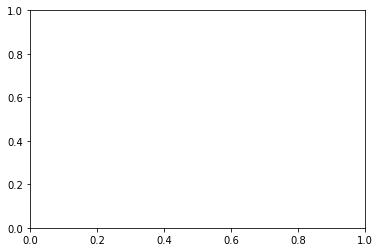

In [26]:
import matplotlib.pyplot as plt
import numpy as np

orders = ['A', 'P', 'B', 'C', 'K', 'O', 'Y', 'N', 'X', 'G', 'Q', 'S', 'J', 'L', 'W',  'Z']

import numpy as np
import matplotlib.pyplot as plt

column_labels = orders
row_labels = orders
fig, ax = plt.subplots()
data = np.array(json_time_table['data'])
vmin=np.nanmin(data)

heatmap = ax.pcolor(data, cmap=plt.cm.seismic, 
                    vmin=np.nanmin(data), vmax=np.nanmax(data))
heatmap.cmap.set_under('black')

bar = fig.colorbar(heatmap, extend='both')

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
plt.show() 

In [109]:
vmin=np.nanmin(data)

TypeError: '<=' not supported between instances of 'NoneType' and 'float'